#### Creating a model for the https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification dataset.

In [1]:
extensions_loaded = False
if not extensions_loaded:
    %load_ext autoreload
    %load_ext tensorboard
    extensions_loaded = True

%autoreload 2
%matplotlib inline

# Initial setup for all models.

In [2]:
import sys
import os
import random

import so_ml_tools as soml

import tensorflow as tf
import keras as ks
import pandas as pd
import numpy as np
import opendatasets as od

import tensorflow_hub as hub

from keras import Model
from keras import layers
from keras import losses
from keras import optimizers

2023-09-28 13:53:31.021546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Download Kaggle Card Image Dataset

In [3]:
od.download_kaggle_dataset(dataset_url="https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification/download?datasetVersionNumber=2", data_dir="./data")

Skipping, found downloaded files in "./data/cards-image-datasetclassification" (use force=True to force download)


### Inspect Dataset

In [4]:
# List the contents of the ./data directory
!ls ./data

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
cards-image-datasetclassification


In [5]:
# List the contents of the ./data/cards-image-datasetclassification directory
!ls ./data/cards-image-datasetclassification

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
cards.csv  test  train	valid


In [6]:
# Delete the two saved models
!rm ./data/cards-image-datasetclassification/*.h5
!ls ./data/cards-image-datasetclassification

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
rm: cannot remove './data/cards-image-datasetclassification/*.h5': No such file or directory
/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
cards.csv  test  train	valid


In [7]:
TRAIN_DIR = './data/cards-image-datasetclassification/train'
TEST_DIR = './data/cards-image-datasetclassification/test'
VALID_DIR = './data/cards-image-datasetclassification/valid'

In [8]:
soml.util.io.list_dir_summary(folder=TRAIN_DIR)

There are 53 directories, and 0 in ./data/cards-image-datasetclassification/train
There are 0 directories, and 152 in ./data/cards-image-datasetclassification/train/six of clubs
There are 0 directories, and 128 in ./data/cards-image-datasetclassification/train/king of clubs
There are 0 directories, and 161 in ./data/cards-image-datasetclassification/train/queen of clubs
There are 0 directories, and 129 in ./data/cards-image-datasetclassification/train/nine of diamonds
There are 0 directories, and 139 in ./data/cards-image-datasetclassification/train/six of diamonds
There are 0 directories, and 139 in ./data/cards-image-datasetclassification/train/queen of hearts
There are 0 directories, and 151 in ./data/cards-image-datasetclassification/train/ten of diamonds
There are 0 directories, and 151 in ./data/cards-image-datasetclassification/train/king of spades
There are 0 directories, and 126 in ./data/cards-image-datasetclassification/train/three of clubs
There are 0 directories, and 157 i

### Visualize some sample data

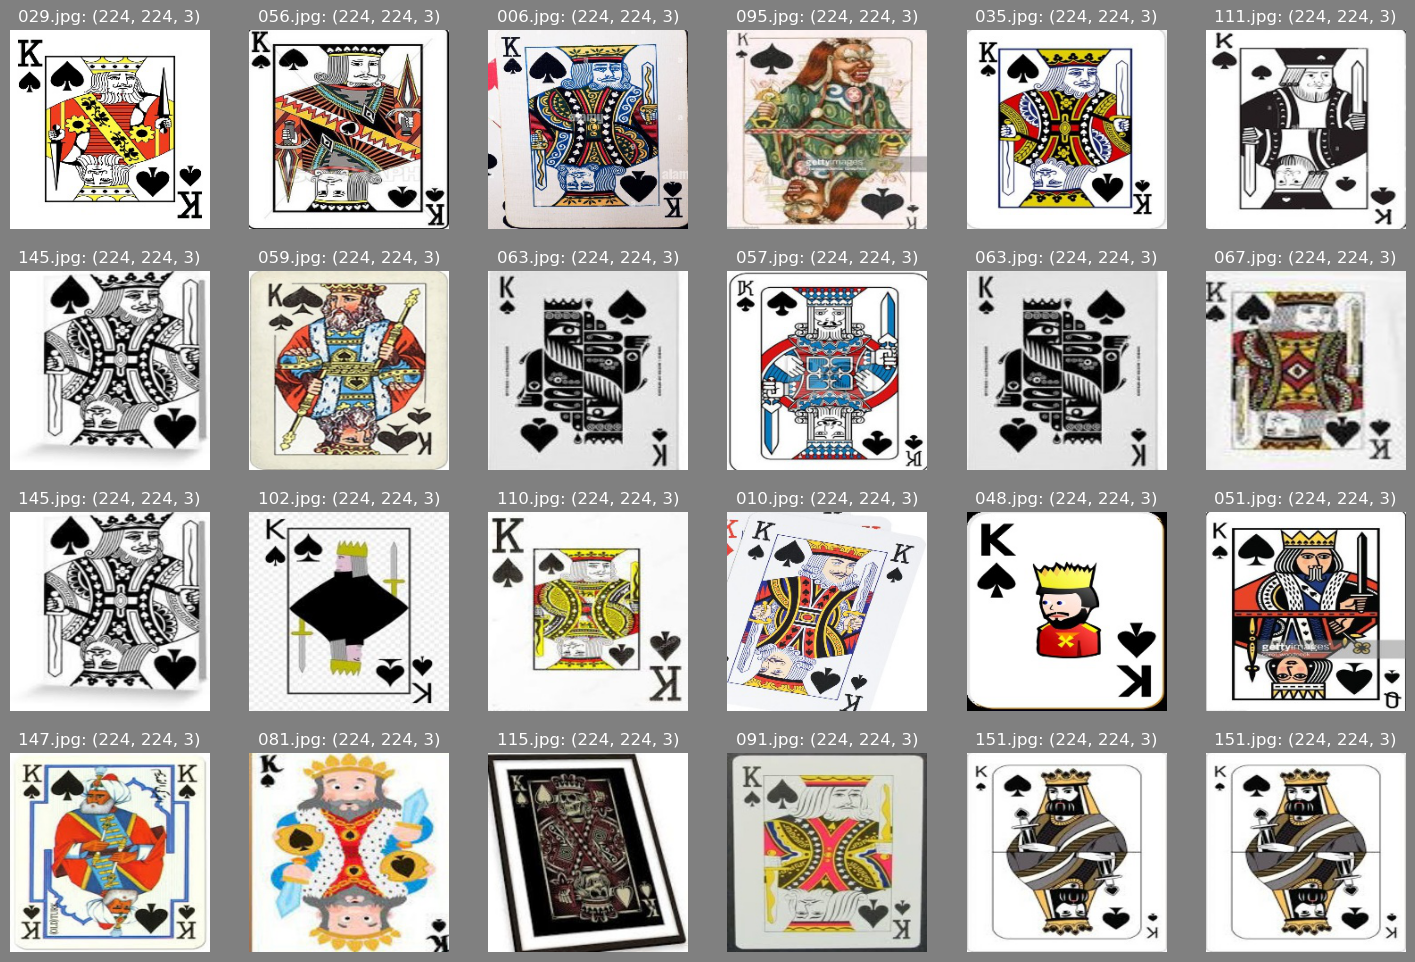

In [9]:
soml.data.image.show_random_image_from_disk(target_dir=TRAIN_DIR, target_class='king of spades')

# Create a base model

### Create datasets

In [10]:
IMG_SHAPE = (180, 180)
BATCH_SIZE = 32

train_dataset = soml.data.loader.load_image_dataset_from_directory(directory=TRAIN_DIR,  
                                                                   image_size=IMG_SHAPE, batch_size=BATCH_SIZE)
test_dataset = soml.data.loader.load_image_dataset_from_directory(directory=TEST_DIR,
                                                                   image_size=IMG_SHAPE, batch_size=BATCH_SIZE)
valid_dataset = soml.data.loader.load_image_dataset_from_directory(directory=VALID_DIR,
                                                                   image_size=IMG_SHAPE, batch_size=BATCH_SIZE, shuffle=False)


train_dataset = soml.tf.dataset.add_prefetching(dataset=soml.tf.dataset.add_shuffling(dataset=soml.tf.dataset.add_caching(dataset=train_dataset)))
test_dataset = soml.tf.dataset.add_prefetching(dataset=soml.tf.dataset.add_shuffling(dataset=soml.tf.dataset.add_caching(dataset=test_dataset)))
valid_dataset = soml.tf.dataset.add_prefetching(dataset=soml.tf.dataset.add_caching(dataset=valid_dataset))

len(train_dataset), len(test_dataset), len(valid_dataset)

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
WARN: Dataset is already shuffled.
Buffer size for shuffle has been set to 1000
WARN: Dataset is already prefetched.
WARN: Dataset is already shuffled.
Buffer size for shuffle has been set to 1000
WARN: Dataset is already prefetched.
WARN: Dataset is already prefetched.


(239, 9, 9)

In [11]:
soml.tf.dataset.describe_inputs_and_outputs(train_dataset)

          | dtype            | shape
Input     | float32          | (None, 180, 180, 3)
Output    | float32          | (None, 53)


In [12]:
soml.tf.dataset.describe_pipeline(train_dataset)

_PrefetchDataset -> _ShuffleDataset -> CacheDataset -> _BatchDataset -> _ShuffleDataset -> _PrefetchDataset -> _ZipDataset

In [13]:
class_names = soml.tf.dataset.get_class_names(dataset=train_dataset)
class_names[:10]

['ace of clubs',
 'ace of diamonds',
 'ace of hearts',
 'ace of spades',
 'eight of clubs',
 'eight of diamonds',
 'eight of hearts',
 'eight of spades',
 'five of clubs',
 'five of diamonds']

### Create model

In [37]:
def conv_layer(x, filters, kernel_size=(2, 2), padding="same"):
    x = ks.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation="relu", padding=padding)(x)
    return ks.layers.MaxPool2D(pool_size=(2, 2))(x)

input_layer = ks.layers.Input(shape=IMG_SHAPE + (3,), name="input_layer")
x = ks.layers.Rescaling(scale=1/255.)(input_layer) # Add rescalign in the model itself, models later on are based on existing models which already include scaling.
x = conv_layer(x=x, filters=16, kernel_size=(3, 3))
x = conv_layer(x=x, filters=32, kernel_size=(3, 3))
x = conv_layer(x=x, filters=64, kernel_size=(3, 3))
x = conv_layer(x=x, filters=128, kernel_size=(3, 3))
x = conv_layer(x=x, filters=256, kernel_size=(3, 3))
x = ks.layers.Dropout(.2)(x)
x = ks.layers.Flatten()(x)
x = ks.layers.Dense(units=128, activation="relu")(x)
output_layer = ks.layers.Dense(units=len(class_names), activation="softmax", name="output_dense_layer")(x)

base_model = Model(input_layer, output_layer)

base_model.compile(loss=ks.losses.CategoricalCrossentropy(label_smoothing=(.1 / len(class_names))),
              optimizer=ks.optimizers.Adam(),
              metrics=["accuracy"])

In [38]:
soml.tf.model.inspect.list_model(base_model)

row   | name (type)                       | dtype   | policy  | trainable | output shape          | Total Param # | Trainable Param # | Non-trainable Param #
0     | input_layer        (InputLayer  ) | float32 | float32 | True      | [(None, 180, 180, 3)] | 0             | 0                 | 0                    
1     | rescaling_8        (Rescaling   ) | float32 | float32 | True      | (None, 180, 180, 3)   | 0             | 0                 | 0                    
2     | conv2d_30          (Conv2D      ) | float32 | float32 | True      | (None, 180, 180, 16)  | 448           | 448               | 0                    
3     | max_pooling2d_30   (MaxPooling2D) | float32 | float32 | True      | (None, 90, 90, 16)    | 0             | 0                 | 0                    
4     | conv2d_31          (Conv2D      ) | float32 | float32 | True      | (None, 90, 90, 32)    | 4,640         | 4,640             | 0                    
5     | max_pooling2d_31   (MaxPooling2D) | float32 

### Fit the base model

In [39]:
reduce_lr_on_plateau_callback = soml.tf.fit.callback.reduce_lr_on_plateau_callback()
early_stopping_callback = soml.tf.fit.callback.early_stopping_callback();

history_base_model = base_model.fit(train_dataset,
                                    steps_per_epoch=len(train_dataset),
                                    validation_data=test_dataset,
                                    validation_steps=len(test_dataset),
                                    epochs=100, 
                                    callbacks=[reduce_lr_on_plateau_callback, early_stopping_callback])

Epoch 1/100


2023-09-28 14:02:17.210433: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


239/239 [==============================] - 2s 5ms/step - loss: 3.2212 - accuracy: 0.1633 - val_loss: 1.9416 - val_accuracy: 0.4038 - lr: 0.0010
Epoch 2/100
239/239 [==============================] - 1s 5ms/step - loss: 1.8535 - accuracy: 0.4814 - val_loss: 1.2242 - val_accuracy: 0.6755 - lr: 0.0010
Epoch 3/100
239/239 [==============================] - 1s 4ms/step - loss: 1.3365 - accuracy: 0.6367 - val_loss: 0.9751 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.9935 - accuracy: 0.7290 - val_loss: 0.6857 - val_accuracy: 0.8189 - lr: 0.0010
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 0.7346 - accuracy: 0.7960 - val_loss: 0.6951 - val_accuracy: 0.8038 - lr: 0.0010
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 0.5211 - accuracy: 0.8568 - val_loss: 0.6256 - val_accuracy: 0.8415 - lr: 0.0010
Epoch 7/100
239/239 [==============================] - 1s 4ms/step - loss: 0

### Evaluate the base model

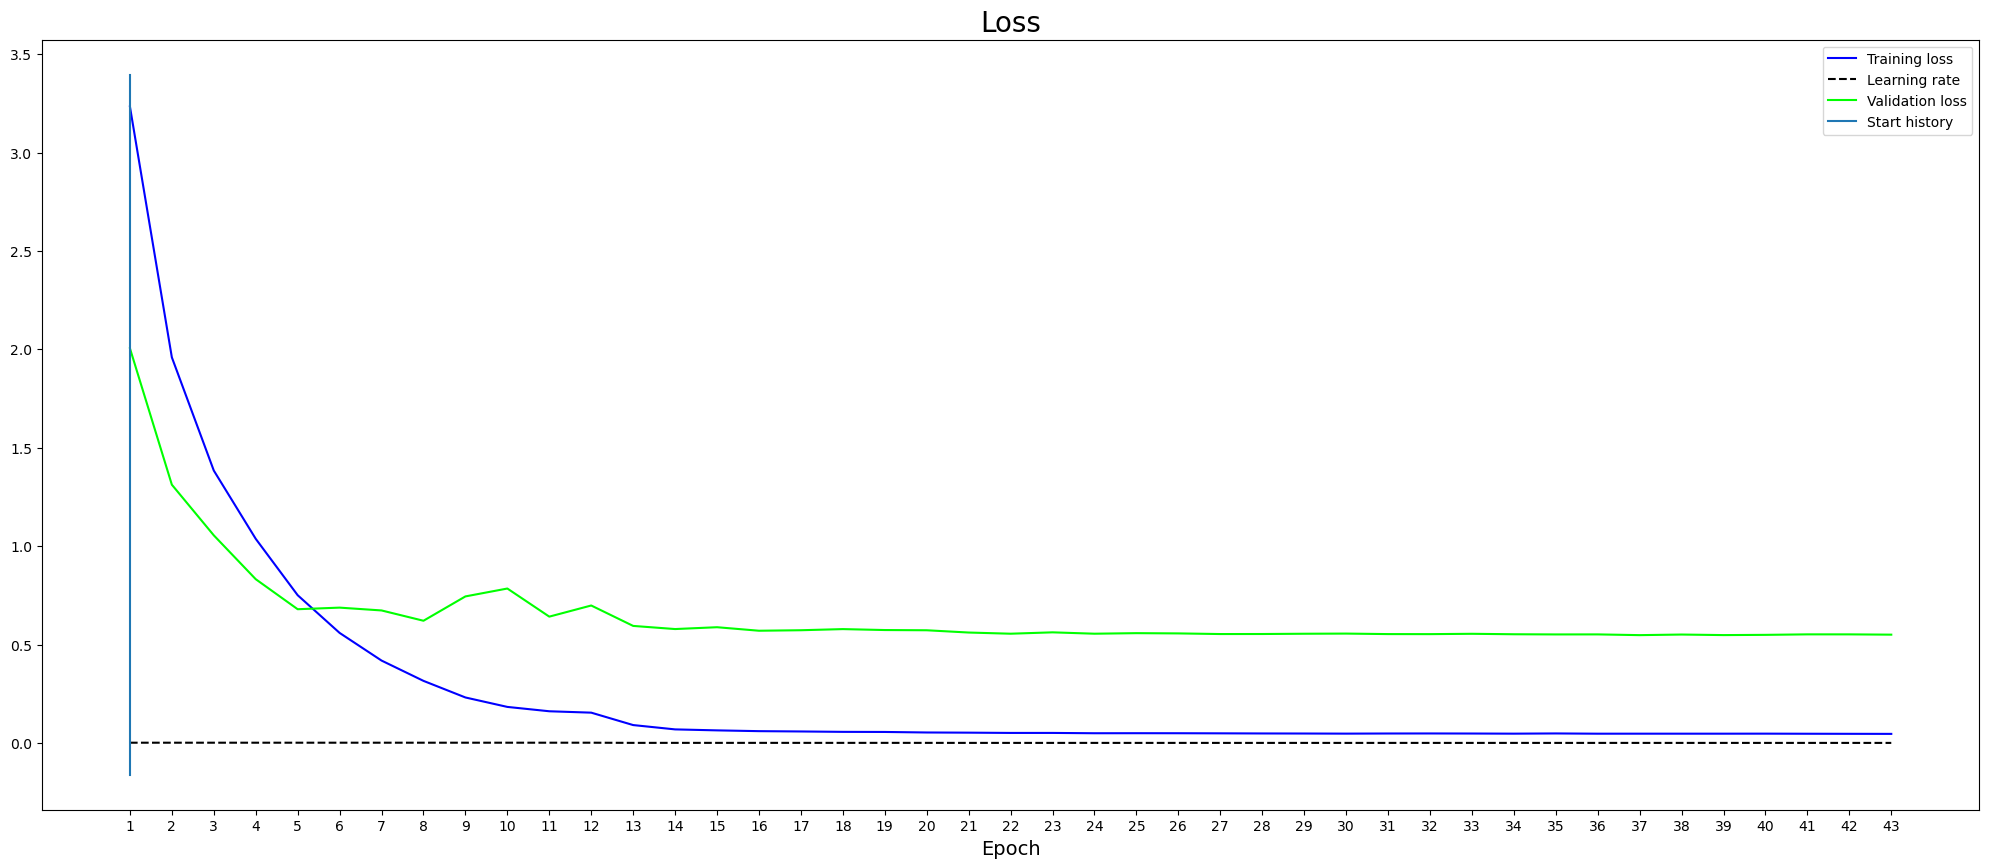

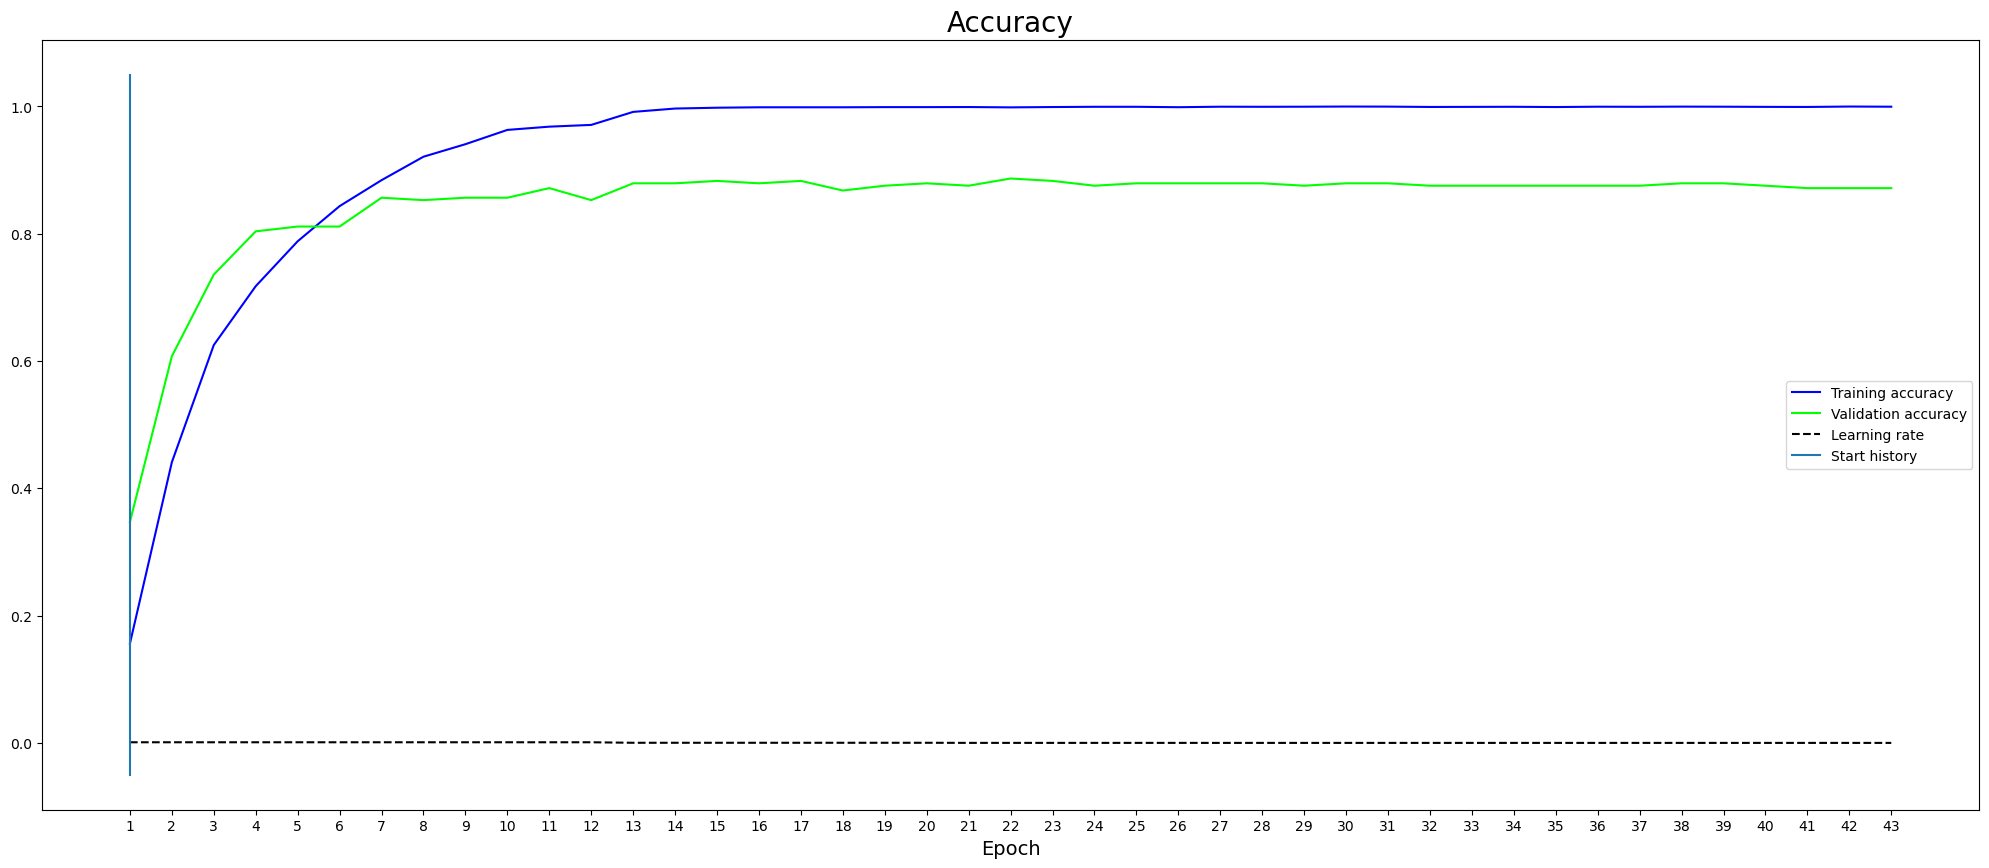

In [20]:
soml.tf.model.plot.plot_history(history_base_model, figsize=(25, 10))

In [21]:
y_prob = base_model.predict(valid_dataset)
len(y_prob)

9/9 [==============================] - 0s 2ms/step


265

In [22]:
y_true = soml.tf.dataset.get_labels(dataset=valid_dataset)
len(y_true)

265

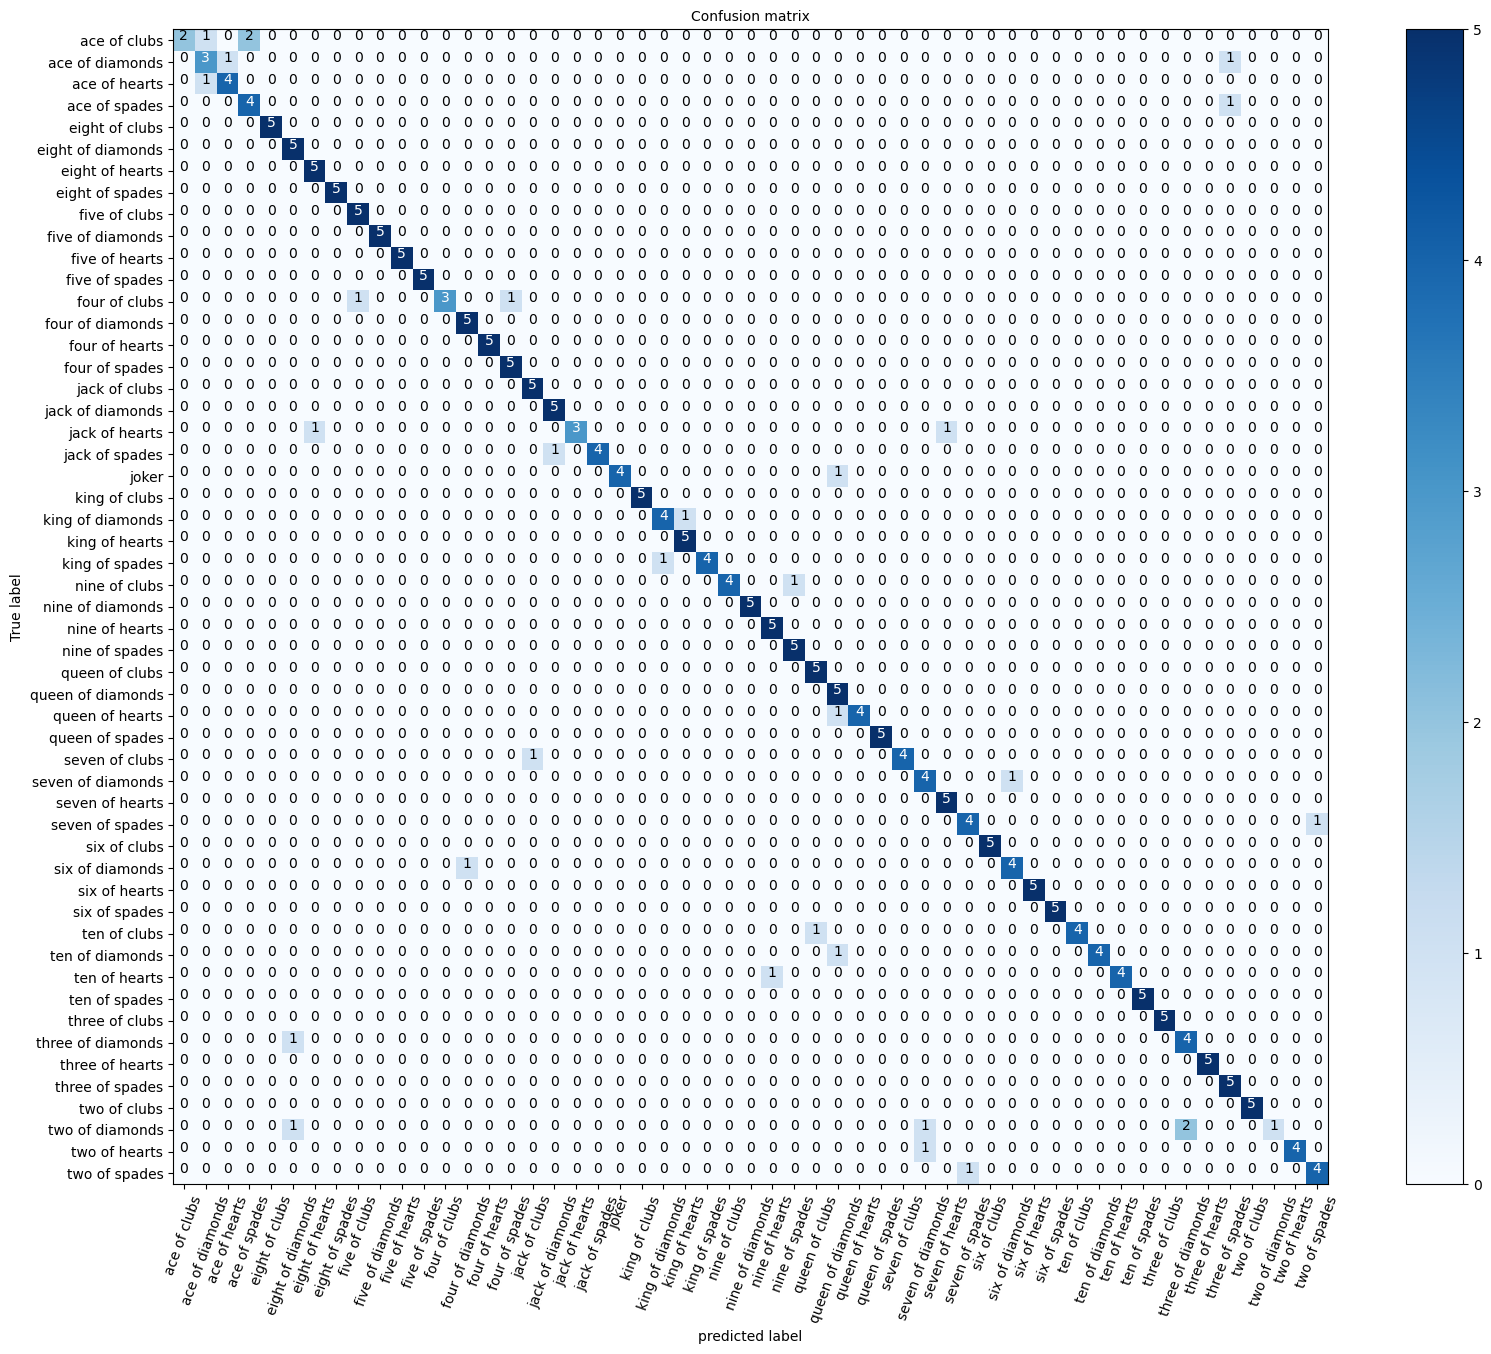

In [40]:
soml.evaluate.plot.confusion_matrix(y_true=y_true, y_prob=y_prob, class_names=class_names, figsize=(20, 15))

In [49]:
soml.evaluate.analyze.quality_metrics(y_true=y_true, y_prob=y_prob)

,accuracy,f1-score,precision,recall
0,88.301887,0.877573,0.902269,0.883019
